# Credit Risk Mini‑Case: Give Me Some Credit (Logistic Regression)
**Goal (business):** predict probability of financial distress within 2 years and design an approval policy that maximizes expected profit (or profit under risk constraints).

**Deliverable:** a clean, reproducible baseline (LogReg) + calibration + decile analysis + champion–challenger policy comparison + monitoring checklist.

> This notebook is structured like a lightweight “model card”: problem → data → modeling → decision policy → monitoring.


## 0) Setup (Colab)
1. Upload `cs-training.csv` to the Colab runtime (Files sidebar) **or** mount Google Drive.
2. Update `DATA_PATH` below if needed.

We intentionally avoid gradient boosting to keep the baseline interpretable and close to classic credit scoring.

In [7]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import matplotlib.pyplot as plt

# --- Config ---
DATA_PATH = "cs-training.csv"   # change if your file is elsewhere
TARGET = "SeriousDlqin2yrs"
RANDOM_STATE = 42


## 1) Load data + quick EDA
We start with: dataset size, base rate, missingness, and obvious data quality issues (outliers).

In [8]:
df = pd.read_csv(DATA_PATH)
display(df.head())

# Often Kaggle exports an index column like "Unnamed: 0"
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

print("Rows, cols:", df.shape)
print("Base rate (distress=1):", round(y.mean(), 5))

missing = X.isna().mean().sort_values(ascending=False)
print("\nMissingness (top):")
display(missing.head(10))


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Rows, cols: (150000, 11)
Base rate (distress=1): 0.06684

Missingness (top):


,0
MonthlyIncome,0.198207
NumberOfDependents,0.026160
age,0.000000
RevolvingUtilizationOfUnsecuredLines,0.000000
DebtRatio,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0.000000
NumberOfOpenCreditLinesAndLoans,0.000000
NumberOfTimes90DaysLate,0.000000
NumberRealEstateLoansOrLines,0.000000
NumberOfTime60-89DaysPastDueNotWorse,0.000000


## 2) Data quality: outliers & sanity checks
This dataset is known for heavy-tailed variables and a few extreme delinquency counts.
For an interpretable baseline, we apply **quantile capping (winsorization)** computed on the training set only (to avoid leakage).

In [9]:
# Quick sanity checks for a few known heavy-tail columns
summary_cols = [
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "age",
]
for c in summary_cols:
    if c in X.columns:
        s = X[c]
        desc = s.describe(percentiles=[0.5, 0.9, 0.95, 0.99, 0.999])
        print(f"\n{c}")
        display(desc)



RevolvingUtilizationOfUnsecuredLines


,RevolvingUtilizationOfUnsecuredLines
count,150000.000000
mean,6.048438
std,249.755371
min,0.000000
50%,0.154181
90%,0.981278
95%,1.000000
99%,1.092956
99.9%,1571.006000
max,50708.000000



DebtRatio


,DebtRatio
count,150000.000000
mean,353.005076
std,2037.818523
min,0.000000
50%,0.366508
90%,1267.000000
95%,2449.000000
99%,4979.040000
99.9%,10613.074000
max,329664.000000



MonthlyIncome


,MonthlyIncome
count,1.202690e+05
mean,6.670221e+03
std,1.438467e+04
min,0.000000e+00
50%,5.400000e+03
90%,1.166600e+04
95%,1.458760e+04
99%,2.500000e+04
99.9%,7.839575e+04
max,3.008750e+06



NumberOfTime30-59DaysPastDueNotWorse


,NumberOfTime30-59DaysPastDueNotWorse
count,150000.000000
mean,0.421033
std,4.192781
min,0.000000
50%,0.000000
90%,1.000000
95%,2.000000
99%,4.000000
99.9%,98.000000
max,98.000000



NumberOfTime60-89DaysPastDueNotWorse


,NumberOfTime60-89DaysPastDueNotWorse
count,150000.000000
mean,0.240387
std,4.155179
min,0.000000
50%,0.000000
90%,0.000000
95%,1.000000
99%,2.000000
99.9%,98.000000
max,98.000000



NumberOfTimes90DaysLate


,NumberOfTimes90DaysLate
count,150000.000000
mean,0.265973
std,4.169304
min,0.000000
50%,0.000000
90%,0.000000
95%,1.000000
99%,3.000000
99.9%,98.000000
max,98.000000



age


,age
count,150000.000000
mean,52.295207
std,14.771866
min,0.000000
50%,52.000000
90%,72.000000
95%,78.000000
99%,87.000000
99.9%,94.000000
max,109.000000


## 3) Train/Validation/Test split
We use a **stratified** split to preserve the base rate in each subset.

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=RANDOM_STATE, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)
print("Base rate train/valid/test:",
      round(y_train.mean(), 5), round(y_valid.mean(), 5), round(y_test.mean(), 5))


Train: (90000, 10) Valid: (30000, 10) Test: (30000, 10)
Base rate train/valid/test: 0.06684 0.06683 0.06683


## 4) Preprocessing: Train-only quantile capping + imputation + missingness flags + scaling
Why this matters:
- Logistic regression is sensitive to extreme values.
- We cap each numeric feature to [1%, 99%] quantiles computed on **train only**.
- Missing values are imputed with the median.
- Features are standardized (mean=0, std=1).

In [11]:
from dataclasses import dataclass

@dataclass
class PreprocParams:
    """Train-fitted preprocessing parameters to avoid leakage."""
    medians: pd.Series
    q_low: pd.Series
    q_high: pd.Series

def fit_preproc_params(X_train: pd.DataFrame, low_q=0.01, high_q=0.99) -> PreprocParams:
    """Fit median imputation and quantile caps on TRAIN only."""
    med = X_train.median(numeric_only=True)
    ql = X_train.quantile(low_q, numeric_only=True)
    qh = X_train.quantile(high_q, numeric_only=True)
    return PreprocParams(medians=med, q_low=ql, q_high=qh)

def apply_preproc(X: pd.DataFrame, params: PreprocParams) -> pd.DataFrame:
    """Apply safe preprocessing:
    - missingness flags (income/dependents if present)
    - simple delinquency flags
    - median imputation (train medians)
    - quantile capping (train quantiles)
    """
    Xp = X.copy()

    # Missingness flags (risk-like)
    for col in ["MonthlyIncome", "NumberOfDependents"]:
        if col in Xp.columns:
            Xp[f"{col}_missing"] = Xp[col].isna().astype(int)

    # Simple delinquency flags (risk-like)
    delin_cols = [
        "NumberOfTime30-59DaysPastDueNotWorse",
        "NumberOfTime60-89DaysPastDueNotWorse",
        "NumberOfTimes90DaysLate",
    ]
    for col in delin_cols:
        if col in Xp.columns:
            Xp[f"{col}_gt0"] = (Xp[col].fillna(0) > 0).astype(int)

    if all(col in Xp.columns for col in delin_cols):
        Xp["any_delinquency"] = (
            (Xp[delin_cols[0]].fillna(0) > 0) |
            (Xp[delin_cols[1]].fillna(0) > 0) |
            (Xp[delin_cols[2]].fillna(0) > 0)
        ).astype(int)

    # Median imputation using train medians
    for col in params.medians.index:
        if col in Xp.columns:
            Xp[col] = Xp[col].fillna(params.medians[col])

    # Quantile capping using train quantiles
    for col in params.q_low.index:
        if col in Xp.columns:
            Xp[col] = Xp[col].clip(params.q_low[col], params.q_high[col])

    return Xp

# --- Fit on TRAIN only, then transform train/valid/test ---
params = fit_preproc_params(X_train, low_q=0.01, high_q=0.99)

X_train = apply_preproc(X_train, params)
X_valid = apply_preproc(X_valid, params)
X_test  = apply_preproc(X_test,  params)

print("After preprocessing:", X_train.shape, X_valid.shape, X_test.shape)


After preprocessing: (90000, 16) (30000, 16) (30000, 16)


## 5) Baseline model: Logistic Regression
This is a classic credit-scoring baseline: interpretable, stable, and easy to monitor.

In [19]:
logreg = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, solver="lbfgs"))
])

logreg.fit(X_train, y_train)

p_valid = logreg.predict_proba(X_valid)[:, 1]
p_test  = logreg.predict_proba(X_test)[:, 1]

def ks_stat(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return float(np.max(np.abs(tpr - fpr)))

print("AUC valid:", round(roc_auc_score(y_valid, p_valid), 6))
print("AUC test :", round(roc_auc_score(y_test,  p_test),  6))
print("KS  valid:", round(ks_stat(y_valid, p_valid), 6))
print("KS  test :", round(ks_stat(y_test,  p_test),  6))


AUC valid: 0.859037
AUC test : 0.859613
KS  valid: 0.568835
KS  test : 0.559592


## 6) Calibration (Platt scaling)
Even when ranking is good (high AUC), raw probabilities may be poorly calibrated.
We calibrate to make PDs more reliable for profitability modeling.

AUC test (cal): 0.859606
KS  test (cal): 0.559415


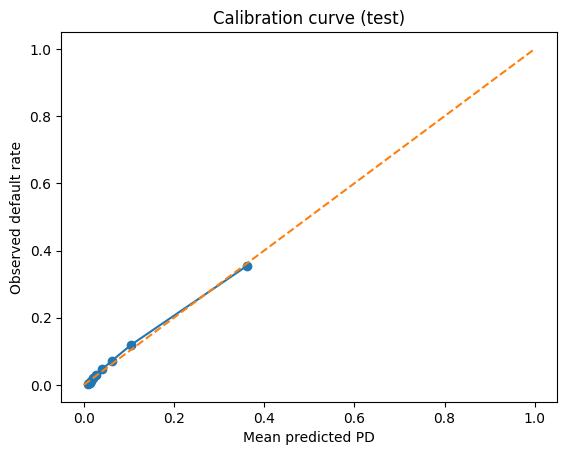

In [20]:
cal_model = CalibratedClassifierCV(logreg, method="sigmoid", cv=3)
cal_model.fit(X_train, y_train)

p_test_cal = cal_model.predict_proba(X_test)[:, 1]

print("AUC test (cal):", round(roc_auc_score(y_test, p_test_cal), 6))
print("KS  test (cal):", round(ks_stat(y_test, p_test_cal), 6))

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, p_test_cal, n_bins=10, strategy="quantile")

plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Mean predicted PD")
plt.ylabel("Observed default rate")
plt.title("Calibration curve (test)")
plt.show()


## 7) Decile analysis (risk segmentation)
A standard credit-risk report: split applicants into deciles by score and inspect bad rate + lift.
This helps stakeholders understand **how much concentration of risk** the model captures.

Overall base rate: 0.06683


,decile,n,bads,avg_pd,badrate,share_of_bads,cum_share_of_bads,lift_vs_overall
0,1,3000,12,0.008291,0.004000,0.005985,0.005985,0.059850
1,2,3000,17,0.011377,0.005667,0.008479,0.014464,0.084788
2,3,3000,21,0.013944,0.007000,0.010474,0.024938,0.104738
3,4,3000,38,0.016875,0.012667,0.018953,0.043890,0.189526
4,5,3000,61,0.020841,0.020333,0.030424,0.074314,0.304239
5,6,3000,86,0.027625,0.028667,0.042893,0.117207,0.428928
6,7,3000,139,0.040497,0.046333,0.069327,0.186534,0.693267
7,8,3000,214,0.061603,0.071333,0.106733,0.293267,1.067332
8,9,3000,356,0.104291,0.118667,0.177556,0.470823,1.775561
9,10,3000,1061,0.361133,0.353667,0.529177,1.000000,5.291771


Highest-risk decile captures 52.9% of bads with 35.4% bad rate


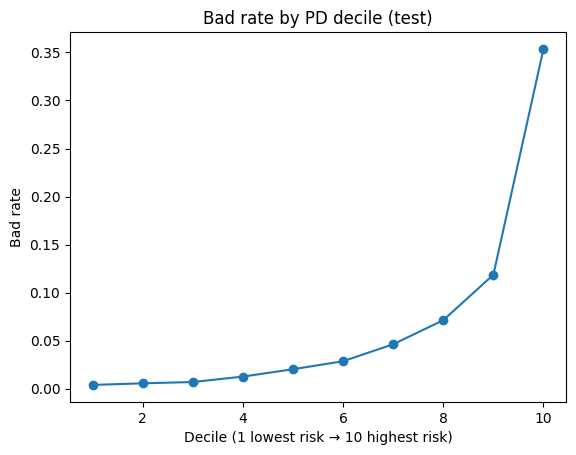

In [21]:
def decile_table(y_true: np.ndarray, score: np.ndarray, n_bins: int = 10) -> pd.DataFrame:
    """Credit-scoring style decile table.

    We define decile=1 as **lowest risk**, decile=10 as **highest risk** (largest PD).
    """
    d = pd.DataFrame({"y": np.asarray(y_true), "score": np.asarray(score)})
    d["decile"] = pd.qcut(d["score"], q=n_bins, labels=False, duplicates="drop") + 1

    out = (d.groupby("decile", as_index=False)
             .agg(n=("y", "size"),
                  bads=("y", "sum"),
                  avg_pd=("score", "mean")))

    out["badrate"] = out["bads"] / out["n"]

    total_bads = d["y"].sum()
    overall_badrate = d["y"].mean()

    out["share_of_bads"] = out["bads"] / total_bads
    out["cum_share_of_bads"] = out["share_of_bads"].cumsum()
    out["lift_vs_overall"] = out["badrate"] / overall_badrate

    out = out.sort_values("decile").reset_index(drop=True)
    return out

dt = decile_table(y_test, p_test_cal, n_bins=10)
print("Overall base rate:", round(y_test.mean(), 5))
display(dt)

# Highest-risk decile = 10
top = dt[dt["decile"] == dt["decile"].max()].iloc[0]
print(f"Highest-risk decile captures {top['share_of_bads']:.1%} of bads with {top['badrate']:.1%} bad rate")

plt.figure()
plt.plot(dt["decile"], dt["badrate"], marker="o")
plt.xlabel("Decile (1 lowest risk → 10 highest risk)")
plt.ylabel("Bad rate")
plt.title("Bad rate by PD decile (test)")
plt.show()


## 8) Decision policy: approval cut-off & expected profit
Now we translate PD into a decision.

### Unit economics (simplified)
- If an approved borrower is **good** → we earn **R** (net revenue per loan)
- If they **default** → we lose **L** (loss per bad loan, includes LGD×EAD + ops)

For each threshold *t* (approve if PD < t), we compute:
- Approval rate
- Bad rate among approved
- Expected profit (per applicant)

You can tune R and L to match Skyro-like product economics.

Best threshold (max profit per applicant):


,11
threshold,0.046054
approval_rate,0.681800
bad_rate,0.016720
profit_per_applicant,6.108428
profit_per_approved,8.959267


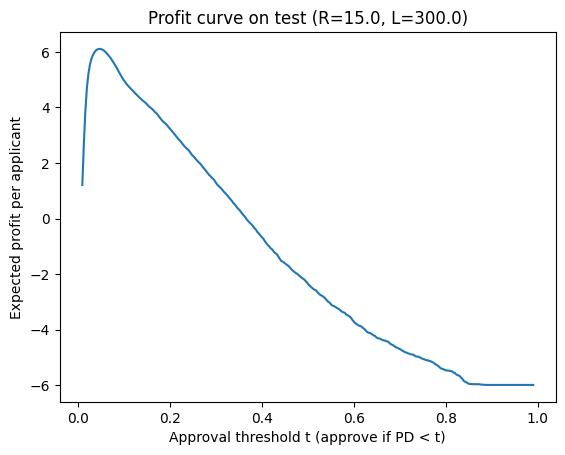

In [22]:
def profit_curve(y_true, pd_score, R=15.0, L=300.0, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 300)
    y_true = np.asarray(y_true)
    pd_score = np.asarray(pd_score)

    rows = []
    for t in thresholds:
        approved = pd_score < t
        if approved.sum() == 0:
            continue
        approval_rate = approved.mean()
        bad_rate = y_true[approved].mean()
        exp_profit_total = ((1 - pd_score[approved]) * R - pd_score[approved] * L).sum()
        profit_per_applicant = exp_profit_total / len(pd_score)
        profit_per_approved = exp_profit_total / approved.sum()
        rows.append([t, approval_rate, bad_rate, profit_per_applicant, profit_per_approved])

    return pd.DataFrame(rows, columns=[
        "threshold", "approval_rate", "bad_rate", "profit_per_applicant", "profit_per_approved"
    ])

# Choose economics (edit these)
R = 15.0   # profit per good loan
L = 300.0  # loss per bad loan (bigger => stricter policy)

curve = profit_curve(y_test, p_test_cal, R=R, L=L)
best = curve.loc[curve["profit_per_applicant"].idxmax()]

print("Best threshold (max profit per applicant):")
display(best)

plt.figure()
plt.plot(curve["threshold"], curve["profit_per_applicant"])
plt.xlabel("Approval threshold t (approve if PD < t)")
plt.ylabel("Expected profit per applicant")
plt.title(f"Profit curve on test (R={R}, L={L})")
plt.show()


### Risk appetite constraints (optional)

In production, risk teams rarely choose a cut-off purely by maximum profit.  
They often set **constraints** such as:
- Bad rate among approved ≤ *X%* (risk appetite / collections capacity)
- Approval rate ≥ *Y%* (growth / unit economics needs)

Below we select the profit‑maximizing threshold under constraints.


Best threshold under constraints:


,11
threshold,0.046054
approval_rate,0.681800
bad_rate,0.016720
profit_per_applicant,6.108428
profit_per_approved,8.959267


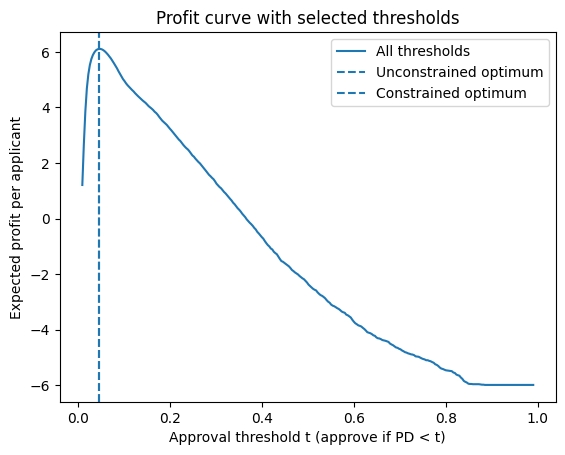

In [23]:
# --- Constraint-based threshold selection (edit these) ---
BAD_RATE_MAX = 0.02      # e.g., 2% max bad rate among approved (set None to disable)
APPROVAL_MIN = None      # e.g., 0.65 min approval rate (set None to disable)

curve_c = curve.copy()
if BAD_RATE_MAX is not None:
    curve_c = curve_c[curve_c["bad_rate"] <= BAD_RATE_MAX]
if APPROVAL_MIN is not None:
    curve_c = curve_c[curve_c["approval_rate"] >= APPROVAL_MIN]

if curve_c.empty:
    print("No thresholds satisfy the constraints. Relax BAD_RATE_MAX / APPROVAL_MIN.")
else:
    best_c = curve_c.loc[curve_c["profit_per_applicant"].idxmax()]
    print("Best threshold under constraints:")
    display(best_c)

    # Visual cue on the profit curve
    plt.figure()
    plt.plot(curve["threshold"], curve["profit_per_applicant"], label="All thresholds")
    plt.axvline(best["threshold"], linestyle="--", label="Unconstrained optimum")
    plt.axvline(best_c["threshold"], linestyle="--", label="Constrained optimum")
    plt.xlabel("Approval threshold t (approve if PD < t)")
    plt.ylabel("Expected profit per applicant")
    plt.title("Profit curve with selected thresholds")
    plt.legend()
    plt.show()


## 9) Champion vs Challenger
A simple “champion–challenger” comparison:
- **Champion:** a reasonable fixed business cut-off
- **Challenger:** profit-optimal cut-off from the curve

We compare approval rate, bad rate, and profit per applicant.

In [24]:
def policy_metrics(y_true, pd_score, threshold, R, L):
    y_true = np.asarray(y_true)
    pd_score = np.asarray(pd_score)
    approved = pd_score < threshold
    approval_rate = approved.mean()
    bad_rate = y_true[approved].mean() if approved.sum() > 0 else np.nan
    exp_profit_total = ((1 - pd_score[approved]) * R - pd_score[approved] * L).sum() if approved.sum() > 0 else 0.0
    profit_per_applicant = exp_profit_total / len(pd_score)
    return {
        "threshold": float(threshold),
        "approved_n": int(approved.sum()),
        "approval_rate": float(approval_rate),
        "bad_rate": float(bad_rate),
        "profit_per_applicant": float(profit_per_applicant),
    }

champion_t = 0.08  # edit: a plausible starting policy
challenger_t = float(best["threshold"])

champ = policy_metrics(y_test, p_test_cal, champion_t, R, L)
chall = policy_metrics(y_test, p_test_cal, challenger_t, R, L)

report = pd.DataFrame([champ, chall], index=["Champion", "Challenger"])
display(report)

uplift = (chall["profit_per_applicant"] / champ["profit_per_applicant"]) - 1
print(f"Profit per applicant uplift (Challenger vs Champion): {uplift:.2%}")


,threshold,approved_n,approval_rate,bad_rate,profit_per_applicant
Champion,0.080000,24359,0.811967,0.025165,5.552493
Challenger,0.046054,20454,0.681800,0.016720,6.108428


Profit per applicant uplift (Challenger vs Champion): 10.01%


## 10) Monitoring checklist
Even the best model fails without monitoring. Here is a minimal, checklist:

**Weekly / daily:**
- Approval rate, bad rate, expected profit (by segment / channel)
- Score distribution drift vs training (PSI for score and key features)
- Data quality: missingness spikes, out-of-range values

**Monthly / quarterly:**
- AUC / KS stability on recent cohorts
- Calibration stability (predicted PD vs observed)
- Policy review: champion–challenger results, cut-off optimization
- Fairness / compliance review (if applicable)

> With real timestamps, add **vintage/cohort** views and roll-rate matrices (30→60→90 DPD).

### Optional: PSI helper (drift)
PSI (Population Stability Index) is a common monitoring metric to track distribution drift for the **score** and key **features** (baseline vs current period).


In [25]:
def psi(expected: np.ndarray, actual: np.ndarray, n_bins: int = 10, eps: float = 1e-6) -> float:
    """Population Stability Index (PSI), using quantile bins from expected (baseline)."""
    expected = np.asarray(expected)
    actual = np.asarray(actual)

    # Remove NaNs
    expected = expected[~np.isnan(expected)]
    actual = actual[~np.isnan(actual)]

    quantiles = np.linspace(0, 1, n_bins + 1)
    bins = np.unique(np.quantile(expected, quantiles))
    if len(bins) < 3:
        return 0.0

    e_counts, _ = np.histogram(expected, bins=bins)
    a_counts, _ = np.histogram(actual,   bins=bins)

    e_perc = e_counts / max(e_counts.sum(), 1)
    a_perc = a_counts / max(a_counts.sum(), 1)

    e_perc = np.clip(e_perc, eps, 1)
    a_perc = np.clip(a_perc, eps, 1)

    return float(np.sum((a_perc - e_perc) * np.log(a_perc / e_perc)))

def psi_for_feature(train_col: pd.Series, test_col: pd.Series, n_bins: int = 10) -> float:
    return psi(train_col.values, test_col.values, n_bins=n_bins)

# Example: score drift proxy (train -> test)
p_train_cal = cal_model.predict_proba(X_train)[:, 1]
psi_score = psi(p_train_cal, p_test_cal, n_bins=10)
print("PSI(score) train→test:", round(psi_score, 4))

# Optional: feature drift proxy (pick a few columns if present)
candidates = [c for c in ["RevolvingUtilizationOfUnsecuredLines", "DebtRatio", "MonthlyIncome", "age"] if c in X_train.columns]
if candidates:
    rows = [(c, psi_for_feature(X_train[c], X_test[c], n_bins=10)) for c in candidates]
    display(pd.DataFrame(rows, columns=["feature", "PSI_train_to_test"]).sort_values("PSI_train_to_test", ascending=False))


PSI(score) train→test: 0.0004


,feature,PSI_train_to_test
0,RevolvingUtilizationOfUnsecuredLines,0.000581
2,MonthlyIncome,0.000400
1,DebtRatio,0.000384
3,age,0.000125


In [30]:
# Dataset + base rate
N = len(y_test)
base_rate = float(y.mean())

# Performance
auc = roc_auc_score(y_test, p_test_cal)
ks  = ks_stat(y_test, p_test_cal)

# Deciles
top = dt[dt["decile"] == dt["decile"].max()].iloc[0]
top10_bads = float(top["share_of_bads"])
top10_bad_rate = float(top["badrate"])

# Profit-optimal (unconstrained)
t = float(best["threshold"])
appr = float(best["approval_rate"])
br = float(best["bad_rate"])

# Constrained (if exists)
br_max = float(BAD_RATE_MAX) if BAD_RATE_MAX is not None else None
if "best_c" in globals() and not pd.isna(best_c.get("threshold", np.nan)):
    t_c = float(best_c["threshold"])
    appr_c = float(best_c["approval_rate"])
    br_c = float(best_c["bad_rate"])
else:
    t_c = appr_c = br_c = np.nan

# Champion–Challenger uplift already computed as `uplift`

print(f"- Dataset size: {N:,}, base default rate: {base_rate:.2%}")
print(f"- Baseline model: Logistic Regression (train-only quantile capping + median imputation + missingness flags + scaling)")
print(f"- Test performance: AUC {auc:.3f}, KS {ks:.3f}")
print(f"- Risk concentration: top decile captures {top10_bads:.1%} of bads with {top10_bad_rate:.1%} bad rate")
print(f"- Profit-optimal policy (R={R:.0f}, L={L:.0f}): threshold t={t:.3f}, approval {appr:.1%}, bad rate {br:.1%}")
if br_max is not None:
    print(f"- Constrained policy (example: bad rate ≤ {br_max:.1%}): threshold t={t_c:.3f}, approval {appr_c:.1%}, bad rate {br_c:.1%}")
print(f"- Champion–Challenger uplift: {uplift:.1%} profit per applicant (trade-off: approval vs risk)")
print(f"- Monitoring proxy (train→test): PSI(score) = {psi_score:.4f}")


- Dataset size: 30,000, base default rate: 6.68%
- Baseline model: Logistic Regression (train-only quantile capping + median imputation + missingness flags + scaling)
- Test performance: AUC 0.860, KS 0.559
- Risk concentration: top decile captures 52.9% of bads with 35.4% bad rate
- Profit-optimal policy (R=15, L=300): threshold t=0.046, approval 68.2%, bad rate 1.7%
- Constrained policy (example: bad rate ≤ 2.0%): threshold t=0.046, approval 68.2%, bad rate 1.7%
- Champion–Challenger uplift: 10.0% profit per applicant (trade-off: approval vs risk)
- Monitoring proxy (train→test): PSI(score) = 0.0004
